# Recurrent artificial neural networks
# Long Short-Term Memory - LSTM
--------

This notebook will guide you through the training and testing of a LSTM network in the task of predicting the speed of a runner for a given slope by using her/his previous speeds during a given race.

Before running the cells in this notebook you have to upload some files with data from some races and the Python module for parsing those files and preparing a dataset.
### left panel -> Files -> Upload
Then select the compressed folder **strava.zip** and the Python module **strava.py**

### OR
Uncomment and update the code in the following cell if your data is in your google drive

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

#!cp 'drive/My Drive/Colab Notebooks/strava.zip' .
#!cp 'drive/My Drive/Colab Notebooks/strava.py' .

Let us start by loading some Python modules

In [67]:
import numpy as np
from matplotlib import pyplot as pl
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import os
import seaborn as sns

from keras.models import Sequential
from keras.layers import Dense, LSTM

from tqdm.notebook import tqdm

import strava as st

Then, let us unzip the compressed file you uploaded

In [63]:
if os.path.exists('strava'):
  print('Data are already in folder')
else:
  if os.path.exists('strava.zip'):
    !unzip strava.zip
  else:
    print('You must upload the data first!')

Data are already in folder


Declare some constants

In [3]:
PATH_DATA = 'strava'

FEATURES = ['time', 'speed', 'slope']    # selected from ['time', 'elevation', 'distance', 'speed', 'slope']
SPEED_OUTLIER = 8.0                      # speed > 30km/h
SLOPE_OUTLIER = 80                       # slope > +-80%
TIME_PERIOD = 1*60                       # period of time to average
SEGMENT_LENGTH = 100                     # length of the segment to average data
AVERAGE_SPEED_TH = 2.4                   # threshold to further clean the dataset

### Read the data
Parse the files in the **strava** folder

In [4]:
importer = st.RunImport(SPEED_OUTLIER, SLOPE_OUTLIER, TIME_PERIOD, SEGMENT_LENGTH, AVERAGE_SPEED_TH)
dataset = importer.import_path(PATH_DATA)

processing 20130630-155546-Run.tab
processing 20140514-151542-Run.tab
processing 20150906-133242-Run.tab
processing 20150510-060418-Run.tab

Race 2 ignored. Average speed: 1.8827972634267185
processing 20130529-161708-Run.tab
processing 20130505-095735-Run.tab
processing 20130105-101007-Run.tab
processing 20141221-154051-Run.tab
processing 20140304-152003-Run.tab
processing 20151025-130239-Run.tab
processing 20120707-091733-Run.tab
processing 20121007-095447-Run.tab
processing 20150823-132029-Run.tab
processing 20150118-101908-Run.tab
processing 20121026-134109-Run.tab
processing 20120422-134215-Run.tab
processing 20150315-104457-Run.tab
processing 20160312-144547-Run.tab
processing 20130917-145343-Run.tab
processing 20120901-154232-Run.tab
processing 20150804-222003-Run.tab
processing 20130815-111754-Run.tab
processing 20140509-170921-Run.tab
processing 20130405-135812-Run.tab
processing 20160131-145858-Run.tab
processing 20130413-131504-Run.tab
processing 20131013-051217-Run.tab
proc

,time,elevation,distance,speed,slope,race
count,20668.000000,20668.000000,20668.000000,20668.000000,20668.000000,20668.000000
mean,1854.441504,771.486180,5455.456205,3.043774,0.000594,114.108622
std,1433.385657,179.491611,4154.601351,0.398492,5.166486,66.517765
min,0.000000,6.170000,0.000000,0.000000,-23.195081,0.000000
25%,781.000000,755.680000,2292.405653,2.813920,-3.156888,56.000000
50%,1548.000000,798.381667,4587.222821,3.065299,-0.011887,116.000000
75%,2551.000000,830.025893,7594.768761,3.295895,3.117112,172.000000
max,7610.000000,2563.000000,21267.295568,7.864821,27.562581,229.000000



Dataset sample:


,time,elevation,distance,speed,slope,race
0,30,747.137500,99.865612,2.944199,2.941479,0
1,62,748.550000,192.695799,2.893302,1.681219,0
2,106,751.615385,296.102731,2.326730,3.380005,0
3,142,755.110000,398.866402,2.922423,3.702273,0
4,176,756.825000,497.831481,2.853412,1.309198,0
65,2214,745.462500,6597.359163,2.835601,7.277873,229
66,2251,747.725000,6699.825814,2.784182,0.889062,229
67,2289,748.116667,6798.730563,2.619177,0.185372,229
68,2321,748.100000,6889.471151,2.763131,-0.412620,229
69,2345,745.466667,6964.061986,3.122454,-5.968150,229


### Example of a race
The following cell shows an example of the data from a race

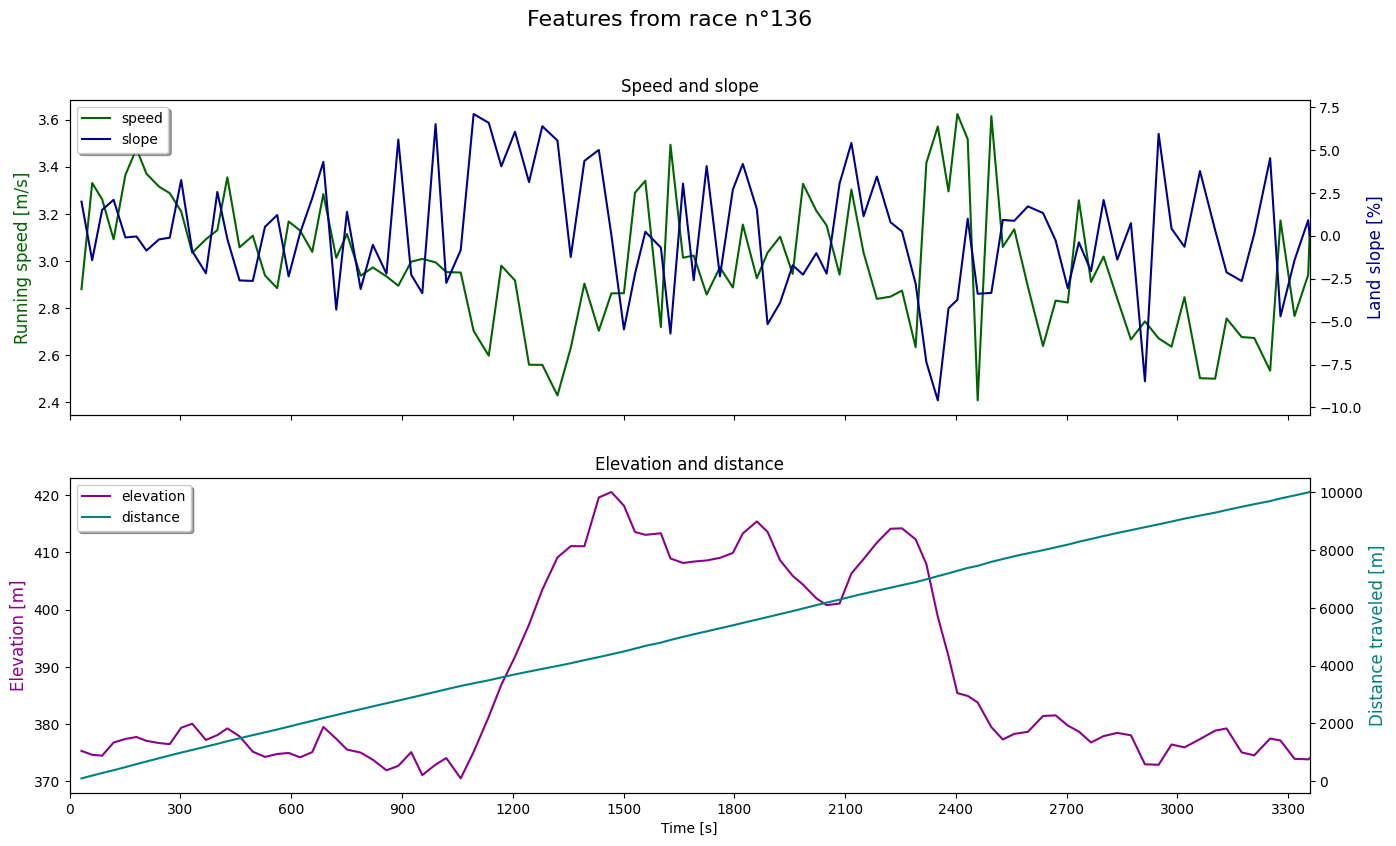

In [5]:
st.plot_race(dataset, np.random.randint(dataset['race'].max()))

### Normalize the dataset
The following cell normalizes the features into the interval [0, 1]

In [6]:
# Copy the dataset before normalisation, feature selection, numpy conversion, etc.
original_dataset = dataset.copy(deep=True)
min_speed = original_dataset['speed'].min()
max_speed = original_dataset['speed'].max()

#normalize only the selected features
#transform to numpy
normalized_dataset = dataset.filter(items=FEATURES).values
scaler = MinMaxScaler()
scaler.fit(normalized_dataset)
normalized_dataset = scaler.transform(normalized_dataset)
#transform back to dataframe
normalized_dataset = pd.DataFrame(normalized_dataset, index=dataset.index, columns=FEATURES)

#update the dataset with the new values
dataset.update(normalized_dataset)

print("Min (per features):", scaler.data_min_)
print("Max (per features):", scaler.data_max_)
display(dataset.head())

Min (per features): [  0.           0.         -23.19508109]
Max (per features): [7610.            7.86482054   27.56258073]


,time,elevation,distance,speed,slope,race
0,0.003942,747.137500,99.865612,0.374350,0.514928,0
1,0.008147,748.550000,192.695799,0.367879,0.490099,0
2,0.013929,751.615385,296.102731,0.295840,0.523568,0
3,0.018660,755.110000,398.866402,0.371582,0.529917,0
4,0.023127,756.825000,497.831481,0.362807,0.482770,0


### Create a training and a testing subset
Split the dataset into training and testing


In [50]:
TIMESTEPS = 2                   #define sequence length
TEST_SIZE = 0.2                  #value between ]0;1[
TRAINING_SIZE = 1 - TEST_SIZE

In [53]:
all_races = np.unique(dataset['race'])
print('Number of races', len(all_races))
RACES_TRAINING = int(np.floor(TRAINING_SIZE * len(all_races)))
races_train = np.random.choice(all_races, RACES_TRAINING, replace=False)
#print(races_training)
races_test = list(set(all_races) - set(races_train))
#print(races_test)
print(len(races_train), 'used during training --- Number of samples', np.sum(np.isin(dataset['race'], races_train)))
print(len(races_test), 'used during test\t --- Number of samples', np.sum(np.isin(dataset['race'], races_test)))

Number of races 230
184 used during training --- Number of samples 16649
46 used during test	 --- Number of samples 4019


### Create inputs and outputs
The folowing cell contains the function that will be used to create the inputs and outputs for training the models

In [88]:
#take a dataframe as input and return the splitted version with the prediction as a numpy array
def create_x_y(data, races, ts):
  speed_index = data[FEATURES].columns.get_loc('speed') #get speed index
  slope_index = data[FEATURES].columns.get_loc('slope') #get slope index
  time_index = data[FEATURES].columns.get_loc('time') #get time index
  x = None
  y = None

  #iterate over every race
  for r in races:
    #filter race
    race_df = data.loc[data['race'] == r]
    #filter features
    race_np = race_df[FEATURES].values
    #split into timesteps (timesteps + 1 to take the target value)
    race_np = [race_np[i:(i+ts+1)] for i in range(race_np.shape[0] - (ts+2))]

    assert len(race_np) > 0, "Warning: not enough values in race"

    race_np = np.stack(race_np, axis=0)

    temp_x = np.dstack([race_np[:,1:,time_index],       # last TIMESTEPS-1 times and next time
                       race_np[:,1:,slope_index],       # last TIMESTEPS-1 slopes and next slope
                       race_np[:,:-1,speed_index]])     # last TIMESTEPS speeds
    temp_y = race_np[:,-1, speed_index]                 # next speed

    if x is None:
      x = temp_x
      y = temp_y
    else:
      x = np.append(x, temp_x, axis=0)
      y = np.append(y, temp_y, axis=0)

  return x, y

In [61]:
print('original shape:', dataset.shape)

X_train, y_train = create_x_y(dataset, races_train, TIMESTEPS)
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

X_test, y_test = create_x_y(dataset, races_test, TIMESTEPS)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)


original shape: (20668, 6)
X_train shape: (15913, 2, 3)
y_train shape: (15913,)
X_test shape: (3835, 2, 3)
y_test shape: (3835,)


### Create a model and train it
The following cells create a LSTM network and train it with the training subset

In [101]:
BATCH_SIZE = 32          # Size of the batch for training
NB_EPOCHS = 20    # Number of times the training dataset is presented
NB_UNITS = [32]         # Number of LSTM units
TIMESTEPS = [12]

hists = {}
scores = {}

# Create and fit the LSTM network
pbar1 = tqdm(total=len(TIMESTEPS))
pbar2 = tqdm()
for ts in TIMESTEPS:
  X_train, y_train = create_x_y(dataset, races_train, ts)
  X_test, y_test = create_x_y(dataset, races_test, ts)
  pbar2.reset(total=len(NB_UNITS))
  for unit in NB_UNITS:
    model = Sequential()
    model.add(LSTM(unit, input_shape=(ts, len(FEATURES))))
    model.add(Dense(1))
    
    model.compile(loss='mean_squared_error', optimizer='adam')
    # model.summary()

    hists[(ts, unit)] = model.fit(X_train, y_train, epochs=NB_EPOCHS, batch_size=BATCH_SIZE, verbose=2, validation_data=(X_test, y_test))

    y_test_pred = model.predict(X_test)
    scores[(ts, unit)] = np.corrcoef(y_test.T, y_test_pred.T)[0,1]
    pbar2.update(1)
  pbar1.update(1)

  0%|          | 0/1 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 1/20
440/440 - 2s - loss: 0.0038 - val_loss: 0.0014 - 2s/epoch - 5ms/step
Epoch 2/20
440/440 - 1s - loss: 0.0015 - val_loss: 0.0013 - 869ms/epoch - 2ms/step
Epoch 3/20
440/440 - 1s - loss: 0.0014 - val_loss: 0.0013 - 851ms/epoch - 2ms/step
Epoch 4/20
440/440 - 1s - loss: 0.0014 - val_loss: 0.0013 - 852ms/epoch - 2ms/step
Epoch 5/20
440/440 - 1s - loss: 0.0014 - val_loss: 0.0012 - 859ms/epoch - 2ms/step
Epoch 6/20
440/440 - 1s - loss: 0.0014 - val_loss: 0.0012 - 875ms/epoch - 2ms/step
Epoch 7/20
440/440 - 1s - loss: 0.0014 - val_loss: 0.0012 - 815ms/epoch - 2ms/step
Epoch 8/20
440/440 - 1s - loss: 0.0014 - val_loss: 0.0013 - 851ms/epoch - 2ms/step
Epoch 9/20
440/440 - 1s - loss: 0.0013 - val_loss: 0.0012 - 873ms/epoch - 2ms/step
Epoch 10/20
440/440 - 1s - loss: 0.0014 - val_loss: 0.0012 - 875ms/epoch - 2ms/step
Epoch 11/20
440/440 - 1s - loss: 0.0014 - val_loss: 0.0012 - 849ms/epoch - 2ms/step
Epoch 12/20
440/440 - 1s - loss: 0.0014 - val_loss: 0.0012 - 837ms/epoch - 2ms/step
Epoc

106/106 [==============================] - 0s 1ms/step


Text(0.5, 1.0, 'Error on low speeds')

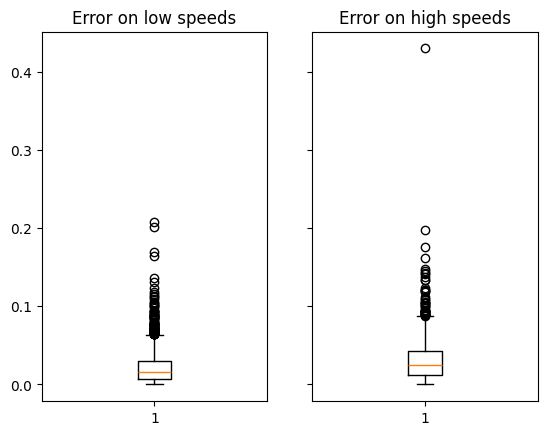

In [171]:
diffs = np.abs((model.predict(X_test).T - y_test).T)
_, ax = pl.subplots(1,2, sharey=True)

ax[1].boxplot(diffs[y_test > 0.4])
ax[1].set_title("Error on high speeds")

ax[0].boxplot(diffs[y_test < 0.4])
ax[0].set_title("Error on low speeds")

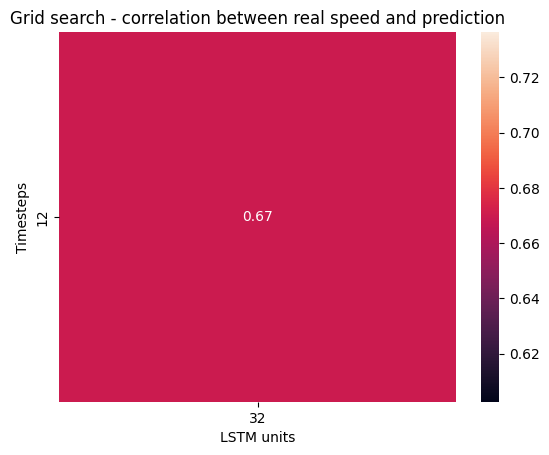

In [102]:
ser = pd.Series(list(scores.values()),
                index=pd.MultiIndex.from_tuples(scores.keys()))
df = ser.unstack().fillna(0)
sns.heatmap(df, annot=True)

pl.title('Grid search - correlation between real speed and prediction')
pl.xlabel('LSTM units')
pl.ylabel('Timesteps');

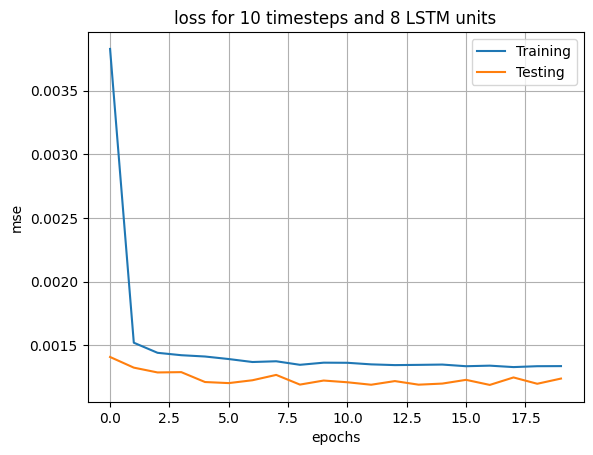

In [103]:
# Plot the training and testing
ts = 12
unit = 32
history = hists[(ts, unit)]

pl.plot(history.history['loss'], label='Training')
pl.plot(history.history['val_loss'], label='Testing')
pl.xlabel('epochs')
pl.ylabel('mse')
pl.title("loss for 10 timesteps and 8 LSTM units")
pl.legend()
pl.grid()

### Evaluate the performance of the model
The following cell computes the correlation between the actual speed of the runner and the model's output

In [227]:
from sklearn.metrics import mean_squared_error

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

print('Training correlation coefficient:', np.corrcoef(y_train.T, y_train_pred.T)[0,1])
print('Test correlation coefficient:', np.corrcoef(y_test.T, y_test_pred.T)[0,1])
print('RMSE of test : ', np.sqrt(mean_squared_error(y_test, y_test_pred.T.T)) * (max_speed - min_speed) + min_speed)

106/106 [==============================] - 0s 833us/step
Training correlation coefficient: 0.6610759225677706
Test correlation coefficient: 0.6694847601794712
RMSE of test :  0.27684567375586566


### Visualize the results
The following cell visualize the output of the LSTM for a single race in the testing subset and compare it with the actual speed of the runner

6/6 [==============================] - 0s 1ms/step
0.7206769203642645


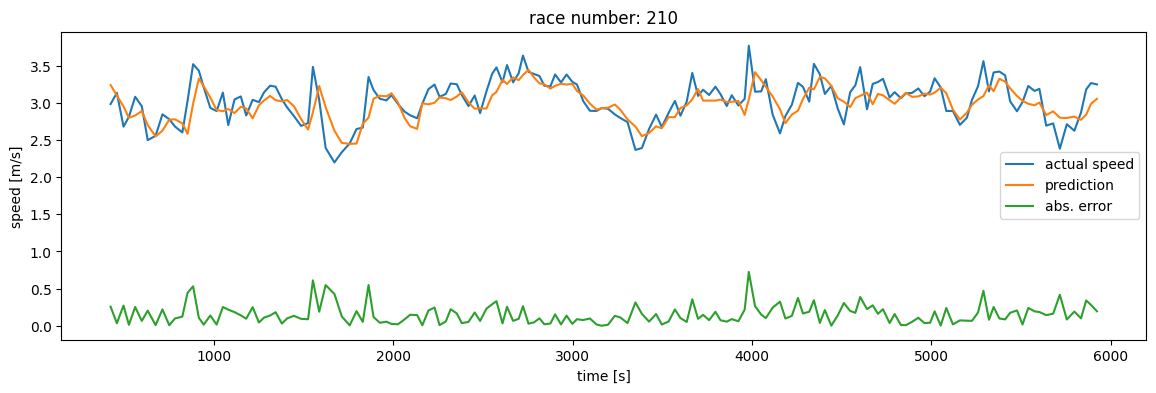

In [213]:
random_race = np.random.choice(races_test)
X, y = create_x_y(dataset, [random_race], TIMESTEPS[-1])
X_o, y_o = create_x_y(original_dataset, [random_race], TIMESTEPS[-1])            # select inputs and output from the unnormalized dataset also

y_pred_o = model.predict(X) * (max_speed - min_speed) + min_speed # unnormalize the prediction

print(np.corrcoef(y_pred_o.T, y_o)[0,1])

pl.figure(figsize=(14,4))
pl.plot(X_o[:,-1,0], y_o, label='actual speed')
pl.plot(X_o[:,-1,0], y_pred_o, label='prediction')
pl.plot(X_o[:,-1,0], np.abs(y_o - y_pred_o[:,0]), label='abs. error')
pl.legend()
pl.title('race number: ' + str(random_race))
pl.xlabel('time [s]')
pl.ylabel('speed [m/s]');


# Exercise

1. Change the number of units and epochs of the LSTM network. Show the configuration that performed the best.
2. What is the largest error (speed prediction) you observed? Do you observe that most of those large errors show up for high speeds ? or low speeds? Why?
3. Using the predicted speeds for a given race, compute the expected time for a race and compute the difference between the real race time and the predicted race time in minutes. Provide the code of the cell that computes this prediction error.

In [199]:
preds = []
truths = []

for idx in np.unique(dataset["race"]):
  race = original_dataset[original_dataset["race"] == idx]
  distance = race["distance"].max()
  time = race["time"].max()
  X, _ = create_x_y(dataset, [idx], TIMESTEPS[-1])
  avg_speed_pred = np.average(model.predict(X)) * (max_speed - min_speed) + min_speed
  preds.append(distance / avg_speed_pred)
  truths.append(time)

2/2 [==============================] - 0s 1ms/step


0.9983968312225905


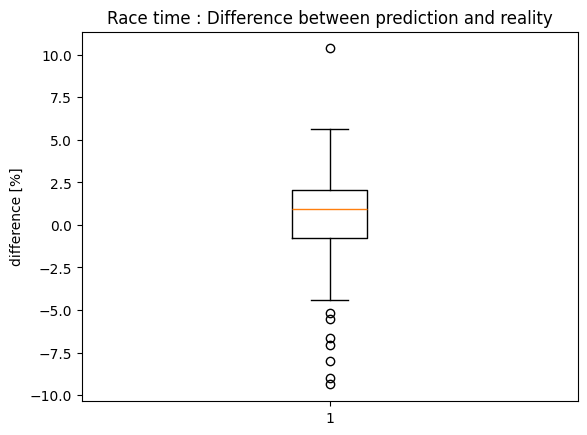

In [235]:
print(np.corrcoef(preds, truths)[0,1])
pl.title("Race time : Difference between prediction and reality")
pl.ylabel("difference [%]")
pl.boxplot(np.subtract(preds, truths) / truths * 100);